# Preprocessing

In [8]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
import pandas as pd

import time
import torch
from torch.autograd import Variable
import sys
sys.path.append("skip-thoughts.torch/pytorch")
from skipthoughts import DropUniSkip

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min


import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize

%matplotlib inline

In [340]:
df = pd.read_csv("unprocessed_posts.csv")
df.head(10)

,query,response
0,"\n\nstarted on 50mg , dr increased to 100 mgdr...",\n\nhi Ingridare you taking sertraline? Someti...
1,\n\nBelow are listed recommended resources for...,\n\r\nawesome resource! thank you! ...
2,\n\nBelow are listed recommended resources for...,"\n\r\nThank you for this, I'm sure lots of peo..."
3,\n\nBelow are listed recommended resources for...,\n\r\nThanx for give informatic information fo...
4,\n\nBelow are listed recommended resources for...,\n\r\nYou are AMAZING for this! Thank you Hun....
5,\n\nHello everyone!\nI am now a couple a years...,"\n\nhi uzumak, i apologise if i have spelt you..."
6,\n\nHello everyone!\nI am now a couple a years...,"\n\nHi Uzumaki, I totally understand not wanti..."
7,"\n\nHello, thanks for reading and I apologize ...","\n\nHi Chantal, I can say quite categorically ..."
8,"\n\nHello, thanks for reading and I apologize ...","\n\r\nAw Chantal, you poor girl this sounds ve..."
9,"\n\nHello, thanks for reading and I apologize ...",\n\nHi ChantalAnxiety can cause us to doubt ev...


In [341]:
# Removing \n and likes/follow counts and Report/Delete text
df["query"] = df["query"].apply(lambda x: re.sub(r'[0-9]+ likes?.*', '', re.sub(r'\n', ' ', x)))
df["response"] = df["response"].apply(lambda x: re.sub(r'Report.*', '', re.sub(r'\n', ' ', x)))

# # Removing anything that isn't a character
# df["query"] = df["query"].apply(lambda x: re.sub(r'[^a-zA-Z.]+', ' ', x))

# Removing pinned post
df.drop(df.index[1:5], inplace = True)
df.reset_index(drop = True, inplace = True)

# Removing links
df["query"] = df["query"].apply(lambda x: re.sub(r'http.*? ', ' ', x))

# Removing None's
df = df[df['query'] != "None"]

Mean query length:  223.8526578213471
Median query length:  157.0


Mean Response length:  94.50384517873744
Median Response length:  67.0


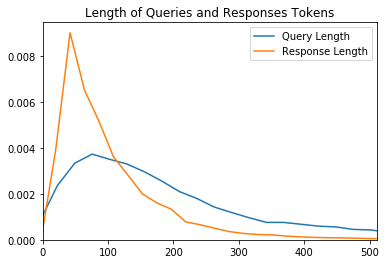

In [342]:
# Naive token assumptions (assuming space separates tokens)

token_len_query = [len(x) for x in [x.split(' ') for x in df["query"]]]
token_len_response = [len(x) for x in [x.split(' ') for x in df["response"]]]

print("Mean query length: ", str(sum(token_len_query)/len(token_len_query)))
print("Median query length: ", statistics.median(token_len_query))
print("\n")
print("Mean Response length: ", str(sum(token_len_response)/len(token_len_response)))
print("Median Response length: ", statistics.median(token_len_response))

g = sns.kdeplot(token_len_query, label = "Query Length")
g = sns.kdeplot(token_len_response, label = "Response Length")
g.set_title("Length of Queries and Responses Tokens")
g.set_xlim(0, 512)
plt.show()

Mean query length:  15.432467806628669
Median query length:  11


Mean Response length:  6.813721764830062
Median Response length:  5
1
1


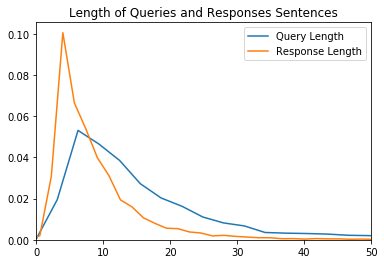

In [87]:
sent_len_query = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["query"]]]]
sent_len_response = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["response"]]]]

print("Mean query length: ", str(sum(sent_len_query)/len(sent_len_query)))
print("Median query length: ", statistics.median(sent_len_query))
print("\n")
print("Mean Response length: ", str(sum(sent_len_response)/len(sent_len_response)))
print("Median Response length: ", statistics.median(sent_len_response))

print(min(sent_len_query))
print(min(sent_len_response))

g = sns.kdeplot(sent_len_query, label = "Query Length")
g = sns.kdeplot(sent_len_response, label = "Response Length")
g.set_title("Length of Queries and Responses Sentences")
g.set_xlim(0, 50)
plt.show()

Mean query length:  11.123094785729364
Median query length:  7.0


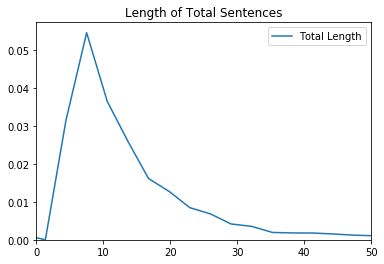

In [81]:
sent_len_query = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["query"]]]]
sent_len_response = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["response"]]]]
total = sent_len_query + sent_len_response

print("Mean query length: ", str(sum(total)/len(total)))
print("Median query length: ", statistics.median(total))

g = sns.kdeplot(total, label = "Total Length")
g.set_title("Length of Total Sentences")
g.set_xlim(0, 50)
plt.show()

# Text Summarization

In [8]:
def summarize(forum_post, clusters=3, model_path = 'models/'):
    try: 
        # Tokenizing and Formatting
        sentences = sent_tokenize(forum_post)
        sentences = [re.sub(r'[^a-zA-Z0-9.!?]', ' ', x) for x in sentences]

        dir_st = model_path
        post = [nltk.tokenize.word_tokenize(x) for x in sentences]
        vocab = list(set([word for sentence in post for word in sentence]))

        raw = []

        for sentence in post:
            temp = []
            for word in sentence:
                temp.append(vocab.index(str(word)))
            raw+=[temp]

        for x in raw:
            if len(x) < max([len(x) for x in raw]):
                x += ["0"]*(max([len(x) for x in raw])-len(x))

        final = []

        for sent in raw:
            temp = []
            for word in sent:
                temp.append(int(word))
            final += [temp]

        # Skipthought summarization
        x = Variable(torch.LongTensor(final))

        uniskip = DropUniSkip(dir_st, vocab)

        output = uniskip(x)
        output = output.detach().numpy()

        # Clustering and summarizing
        n_clusters = clusters
        kmeans = KMeans(n_clusters = n_clusters)
        kmeans = kmeans.fit(output)

        avg = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, output)
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        summary = ' '.join([sentences[closest[idx]] for idx in ordering])

        return summary
    
    except: 
        return ("None")

# Testing with Sample

In [10]:
test = pd.read_csv("test.csv")

# Deleting moderator removed messages
mod_remove = "This reply has been deleted by a moderator"
test["response"] = test["response"].apply(lambda x: "Remove" if mod_remove in str(x) else x)
test = test[test["response"] != "Remove"]
test.reset_index(inplace = True, drop = True)

# Deleting hyperlink messages
hyperlink = "href"
test["response"] = test["response"].apply(lambda x: "Remove" if hyperlink in str(x) else x)
test = test[test["response"] != "Remove"]
test.reset_index(inplace = True, drop = True)

# Removing none for query
test = test[test["summarized_query"] != "None"]
test.reset_index(inplace = True, drop = True)

# Removing None's (mostly responses under 3 sentences)
for x in range(len(test)):
    if test["summarized_response"][int(x)] == "None":
        test["summarized_response"][int(x)] = test["response"][x]

test.head(3)

,query,response,summarized_query,summarized_response
0,"Hello, thanks for reading and I apologize fo...",Hi ChantalAnxiety can cause us to doubt ever...,About a month and a half ago something happen...,You re stressed out. Good Luck What I got from...
1,"Hello, thanks for reading and I apologize fo...",\r I feel your pain.,About a month and a half ago something happen...,\r I feel your pain.
2,"Hello, thanks for reading and I apologize fo...",For me it made me think that people didn't l...,About a month and a half ago something happen...,But since it was constantly on my mind it sur...


### Preprocessing

In [11]:
test["summarized_query"] = test["summarized_query"].str.replace(r'like.*Delete', '')
test["summarized_query"] = test["summarized_query"].str.replace(' {3,}', '')
test["summarized_query"] = test["summarized_query"].str.replace(r'[0-9]', ' ')
test["summarized_query"] = test["summarized_query"].str.replace(r'\.\.\.', '.')
test["summarized_query"] = test["summarized_query"].str.replace(r'\.\.', '.')
test["summarized_query"] = test["summarized_query"].str.replace(r'http.*', ' ')
test["summarized_query"] = test["summarized_query"].str.replace(r'\r', ' ')
test["summarized_query"] = test["summarized_query"].str.replace(r'\xa0', ' ')


test["summarized_response"] = test["summarized_response"].str.replace(r'like.*Delete', '')
test["summarized_response"] = test["summarized_response"].str.replace(' {3,}', '')
test["summarized_response"] = test["summarized_response"].str.replace(r'[0-9]', ' ')
test["summarized_response"] = test["summarized_response"].str.replace(r'\.\.\.', r'.')
test["summarized_response"] = test["summarized_response"].str.replace(r'\.\.', r'.')
test["summarized_response"] = test["summarized_response"].str.replace(r'http.*', ' ')
test["summarized_response"] = test["summarized_response"].str.replace(r'\r', ' ')
test["summarized_response"] = test["summarized_response"].str.replace(r'\xa0', ' ')

def clean_text(text):
    '''Clean text by removing unnecessary characters and altering the format of words.'''

    text = text.lower()
    
    text = re.sub(r" i m ", " i am ", text)
    text = re.sub(r" he s ", " he is ", text)
    text = re.sub(r" she s ", " she is ", text)
    text = re.sub(r" it s ", " it is ", text)
    text = re.sub(r" that s ", " that is ", text)
    text = re.sub(r" what s ", " what is ", text)
    text = re.sub(r" where s ", " where is ", text)
    text = re.sub(r" how s ", " how is ", text)
    text = re.sub(r" ll ", " will ", text)
    text = re.sub(r" ve ", " have ", text)
    text = re.sub(r" re ", " are ", text)
    text = re.sub(r" d ", " would ", text)
    text = re.sub(r" re ", " are ", text)
    text = re.sub(r" won t ", " will not ", text)
    text = re.sub(r" can t ", " cannot ", text)
    text = re.sub(r"n t ", " not ", text)
    text = re.sub(r" bout ", " about ", text)
    text = re.sub(r" til ", " until ", text)
    text = re.sub(r" cant ", " cannot ", text)
    
    return text

test["summarized_response"] = test["summarized_response"].apply(clean_text)
test["summarized_query"] = test["summarized_query"].apply(clean_text)

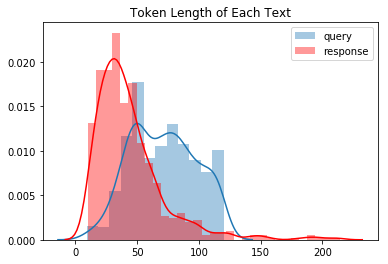

In [15]:
# Dropping all responses that are too short
min_cut_off = 10
a = [len(x) for x in [x.split(" ") for x in test["summarized_response"]]]
b = np.array(a)
drop_list = list(np.where(b<min_cut_off)[0])

test.drop(drop_list, inplace = True)
test.reset_index(inplace = True, drop = True)

# Dropping all queries that are too long
max_cut_off = 120
a = [len(x) for x in [x.split(" ") for x in test["summarized_query"]]]
b = np.array(a)
drop_list = list(np.where(b>max_cut_off)[0])

test.drop(drop_list, inplace = True)
test.reset_index(inplace = True, drop = True)

# Plotting distribution of number of tokens per text (naive assumptions)
response_dist = [len(x) for x in [x.split(" ") for x in test["summarized_response"]]]
query_dist = [len(x) for x in [x.split(" ") for x in test["summarized_query"]]]

sns.distplot(query_dist, label = "query").set_title("Token Length of Each Text")
sns.distplot(response_dist, label = "response", color = "red")
plt.legend()

### Seq2Seq Model

In [311]:
def tagger(decoder_input_sentence):
    bos = "<BOS> "
    eos = " <EOS>"
    final_target = [bos + text + eos for text in decoder_input_sentence] 
    return final_target

inputs = tagger(test["summarized_query"])
outputs = tagger(test["summarized_response"])

In [312]:
from keras.preprocessing.text import Tokenizer
def vocab_creater(text):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(text)
    dictionary = tokenizer.word_index
    
    word2idx = {}
    idx2word = {}
    
    for k, v in dictionary.items():
        word2idx[k] = v
        idx2word[v] = k
        
    return word2idx, idx2word, tokenizer

all_texts = list(inputs + outputs)
word2idx, idx2word, tokenizer = vocab_creater(all_texts)
vocab_size = len(word2idx) + 1

In [313]:
from keras.preprocessing.sequence import pad_sequences

input_ids = tokenizer.texts_to_sequences(inputs)
output_ids = tokenizer.texts_to_sequences(outputs)

max_len = 150

input_ids_padded = pad_sequences(input_ids, maxlen = max_len, dtype = "int32", padding = "post", truncating = "post")
output_ids_padded = pad_sequences(output_ids, maxlen = max_len, dtype = "int32", padding = "post", truncating = "post")


In [314]:
# Reading in GloVe embeddings
embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

In [315]:
# Creating embedding matrix with our words
embedding_matrix = np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [316]:
from keras.layers import Embedding

embedding_layer = Embedding(input_dim = vocab_size,
                           output_dim = 100,
                           input_length = max_len,
                           weights = [embedding_matrix],
                           trainable = False)

In [317]:
decoder_output_data = np.zeros((len(input_ids), max_len, vocab_size), dtype="float32")

for i, seqs in enumerate(output_ids_padded):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1

In [331]:
from keras.models import Sequential, Model
from keras.layers import LSTM, Input, Dense, TimeDistributed

encoder_inputs = Input(shape=(max_len, ), dtype='int32',)
encoder_embedding = embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(100, return_state=True)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_inputs = Input(shape=(max_len, ), dtype='int32',)
decoder_embedding = embedding_layer(decoder_inputs)
decoder_LSTM = LSTM(100, return_state=True, return_sequences=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states)

# decoder_dense = Dense(VOCAB_SIZE, activation='softmax')
decoder_dense = TimeDistributed(Dense(vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "model_35"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_62 (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
input_61 (InputLayer)           (None, 150)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 150, 100)     354400      input_61[0][0]                   
                                                                 input_62[0][0]                   
__________________________________________________________________________________________________
lstm_25 (LSTM)                  [(None, 100), (None, 80400       embedding_4[4][0]         

In [332]:
model.compile(optimizer = "rmsprop", loss = "categorical_crossentropy", metrics = ["accuracy"])
history = model.fit([input_ids_padded, output_ids_padded], decoder_output_data, 
          batch_size = 64, epochs = 10, validation_split = 0.2)

Train on 490 samples, validate on 123 samples
Epoch 1/10
490/490 [==============================] - 18s 37ms/step - loss: 7.3224 - accuracy: 0.6287 - val_loss: 5.5704 - val_accuracy: 0.7411
Epoch 2/10
490/490 [==============================] - 18s 37ms/step - loss: 4.7794 - accuracy: 0.7067 - val_loss: 3.6731 - val_accuracy: 0.7452
Epoch 3/10
490/490 [==============================] - 18s 37ms/step - loss: 3.3106 - accuracy: 0.7097 - val_loss: 2.5679 - val_accuracy: 0.7452
Epoch 4/10
490/490 [==============================] - 18s 37ms/step - loss: 2.4999 - accuracy: 0.7097 - val_loss: 2.0434 - val_accuracy: 0.7452
Epoch 5/10
490/490 [==============================] - 19s 38ms/step - loss: 2.1478 - accuracy: 0.7097 - val_loss: 1.8313 - val_accuracy: 0.7452
Epoch 6/10
490/490 [==============================] - 18s 36ms/step - loss: 1.9958 - accuracy: 0.7097 - val_loss: 1.7282 - val_accuracy: 0.7452
Epoch 7/10
490/490 [==============================] - 18s 37ms/step - loss: 1.9088 - accur

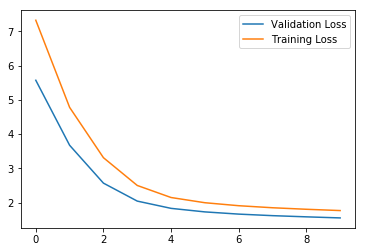

In [335]:
plt.plot(history.history["val_loss"], label = "Validation Loss")
plt.plot(history.history["loss"], label = "Training Loss")
plt.legend()

In [334]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(100,))
decoder_state_input_c = Input(shape=(100,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_LSTM(
    decoder_embedding, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)


In [336]:
reverse_input_char_index = dict(
    (i, char) for char, i in word2idx.items())
reverse_target_char_index = dict(
    (i, char) for char, i in word2idx.items())

In [337]:
def decode_sequence(input_seq):
    # Converting to vector
    input_seq = tokenizer.texts_to_sequences(input_seq)
    input_seq = pad_sequences(input_seq, maxlen = max_len, dtype = "int32", padding = "post", truncating = "post")

    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, max_len))
    # Populate the first character of target sequence with the start character.
    target_seq[0, word2idx["bos"]] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, 1:]) + 1
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > 150):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, max_len))
        target_seq[0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [338]:
decode_sequence('i was looking online about crossing over to another antidepressant and it says come off escotalopram first then introduce new antidepressant.so the thought of having to do that to try another antidepressant that may or may not work is a horrible thought!')


'eoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseoseos'

# Scrap Code

In [35]:
import importlib
importlib.reload(skipthoughts)

<module 'skipthoughts' from 'C:\\Users\\Delbert\\Documents\\Kevin\\Masters\\Thesis\\skipthoughts.py'>

In [344]:
def completion(pattern):
    a = [True if str(pattern) in x else False for x in df["query"]]
    for i,val in enumerate(a):
        if val:
            print("{:.2f}% done".format(i/len(df)*100))
            
completion("My daughter whom I've")

57.38% done
57.38% done
57.39% done
57.39% done
57.39% done
57.40% done
57.40% done
57.41% done
57.41% done
57.42% done
57.42% done
57.42% done
57.43% done
57.43% done
57.44% done
57.44% done


In [147]:
lengths = [len(x) for x in[x.split(" ") for x in test["summarized_response"]]]
lengths.sort(reverse = True)
lengths

[506,
 474,
 248,
 214,
 210,
 207,
 201,
 196,
 194,
 188,
 181,
 175,
 158,
 157,
 157,
 154,
 154,
 153,
 152,
 149,
 148,
 147,
 147,
 145,
 145,
 142,
 140,
 139,
 134,
 127,
 126,
 125,
 125,
 124,
 121,
 120,
 120,
 118,
 118,
 117,
 114,
 114,
 112,
 112,
 109,
 108,
 107,
 106,
 104,
 103,
 103,
 102,
 101,
 101,
 100,
 100,
 99,
 99,
 98,
 98,
 98,
 98,
 98,
 96,
 96,
 95,
 95,
 95,
 95,
 95,
 95,
 95,
 94,
 93,
 93,
 90,
 89,
 89,
 88,
 88,
 87,
 87,
 87,
 87,
 87,
 87,
 86,
 86,
 86,
 85,
 85,
 85,
 84,
 84,
 84,
 84,
 83,
 83,
 83,
 83,
 82,
 81,
 81,
 81,
 80,
 80,
 80,
 79,
 79,
 79,
 78,
 78,
 78,
 78,
 77,
 77,
 76,
 76,
 74,
 74,
 74,
 74,
 74,
 74,
 73,
 73,
 73,
 73,
 72,
 72,
 72,
 71,
 71,
 71,
 70,
 70,
 69,
 69,
 69,
 69,
 68,
 68,
 68,
 68,
 68,
 68,
 68,
 67,
 67,
 67,
 67,
 67,
 67,
 66,
 66,
 66,
 66,
 66,
 65,
 65,
 65,
 65,
 65,
 64,
 64,
 64,
 64,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 63,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 62,
 61,
 61,

In [ ]:
[text.split(".")[:-1] for text in test["summarized_query"]][0]

In [149]:
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences

X_train, X_test, y_train, y_test = train_test_split(test["summarized_query"], test["summarized_response"], test_size = 0.3, random_state = 42)

# Tokenizing
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
y_train = tokenizer.texts_to_sequences(y_test)
X_test = tokenizer.texts_to_sequences(X_test)
y_test = tokenizer.texts_to_sequences(y_test)

#Padding for same input length
vocab_size = len(tokenizer.word_index) + 1
maxlen_X = 370
maxlen_y = 200

X_train = pad_sequences(X_train, padding = "post", maxlen = maxlen_X)
y_train = pad_sequences(X_train, padding = "post", maxlen = maxlen_y)
X_test = pad_sequences(X_test, padding = "post", maxlen = maxlen_X)
y_test = pad_sequences(X_test, padding = "post", maxlen = maxlen_y)

# # Reading in GloVe embeddings
# embeddings_dictionary = dict()
# glove_file = open('glove.6B.100d.txt', encoding="utf8")

# for line in glove_file:
#     records = line.split()
#     word = records[0]
#     vector_dimensions = asarray(records[1:], dtype='float32')
#     embeddings_dictionary [word] = vector_dimensions
# glove_file.close()

# # Creating embedding matrix with our words
# embedding_matrix = zeros((vocab_size, 100))
# for word, index in tokenizer.word_index.items():
#     embedding_vector = embeddings_dictionary.get(word)
#     if embedding_vector is not None:
#         embedding_matrix[index] = embedding_vector